<a href="https://colab.research.google.com/github/guilhermelaviola/LautaroInterGoalsAnalysis/blob/main/LautaroInterGoals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing all the necessary libraries:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
sns.set(style = 'darkgrid')
plt.style.use('seaborn-pastel')

<ipython-input-1-5ddc9a2f5ebc>:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


In [2]:
df = pd.read_excel('lautaro-goals.xlsx')
df.head()

,Competition,Round,Date,H/A,Against,Final score,Position,Minute,Which goal,How was it scored,Assist
0,Serie A,7,2018-09-29,H,Cagliari,02:00:00,CF,12',01:00:00,Header,Dalbert
1,Serie A,13,2018-11-24,H,Frosinone,03:00:00,CF,57',02:00:00,Header,Keita Baldé
2,Serie A,18,2018-12-26,H,Napoli,01:00:00,CF,90'+1,01:00:00,Left-footed shot,NaN
3,Italy Cup,Round of 16,2019-01-13,H,Benevento,06:02:00,SS,48',04:00:00,Header,Ivan Perisic
4,Italy Cup,Round of 16,2019-01-13,H,Benevento,0.251389,SS,66',05:01:00,Right-footed shot,Ivan Perisic


I extracted this data from Transfermarkt.

In [3]:
df.shape

(117, 11)

The dataset has 117 rows at moment (11/28/2023). Each row represents a goal Lautaro scored for Inter. And there are 11 columns:
1. Competition
2. Round
3. Date
4. H/A - Home or Away
5. Against
6. Final Score
7. Position
8. Minute
9. Which goal
10. How was it scored
11. Assist



In [4]:
df.columns = ['Competition', 'Round', 'Date',
              'Home or away', 'Against who',
              'Final score', 'Position',
              'Minute', 'Which goal',
              'How was it scored', 'Assist']

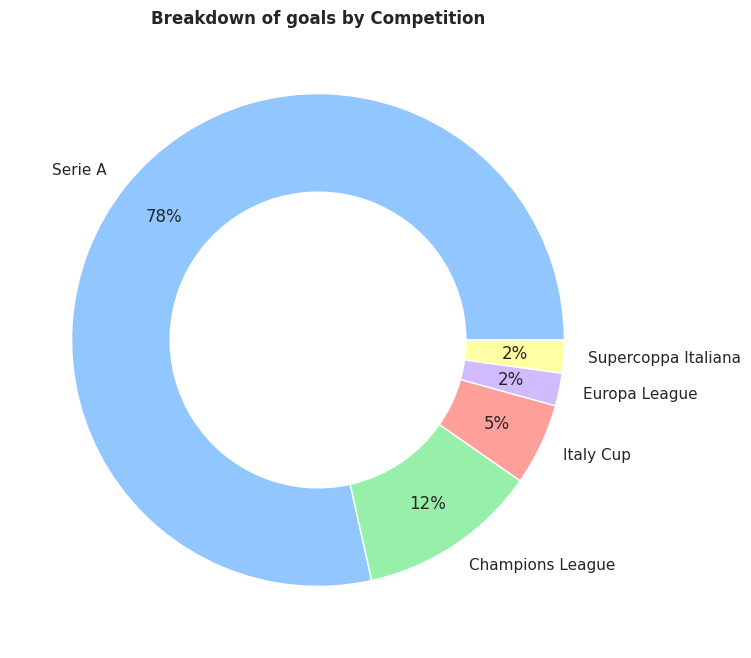

In [6]:
# Displaying goals scored by competition:
df.groupby('Date').first()['Competition'].value_counts().plot(kind = 'pie',
                                                              autopct = '%.0f%%',
                                                              figsize = (8, 8),
                                                              wedgeprops = dict(width = 0.4),
                                                              pctdistance = 0.8)
plt.ylabel(None)
plt.title('Breakdown of goals by Competition', fontweight = 'bold')
plt.show()

In [7]:
# Adding Racing Bar animation for :
df.Date = pd.to_datetime(df.Date, format = '%Y')

In [8]:
#Preparing a pivot table:
racing_bar_data = df.pivot_table(index = 'Date', columns = 'Competition')

<ipython-input-8-bf6f8452fffc>:2: FutureWarning: pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.
  racing_bar_data = df.pivot_table(index = 'Date', columns = 'Competition')


In [9]:
# Checking if there are any null value in the pivot table:
racing_bar_data.columns[racing_bar_data.isnull().sum() == 0]

MultiIndex([], names=[None, 'Competition'])

In [10]:
# Converting the data into a cumulative sum over several years:
racing_bar_filled = racing_bar_data.interpolate(method = 'linear').fillna(method = 'bfill')
racing_bar_filled = racing_bar_filled.cumsum()

In [12]:
# Oversampling the dataset with interpolation (linear) for a smooth transition in the frames of the snimation:
racing_bar_filled = racing_bar_filled.resample('1D').interpolate(method = 'linear')[::7]

NotImplementedError: ignored

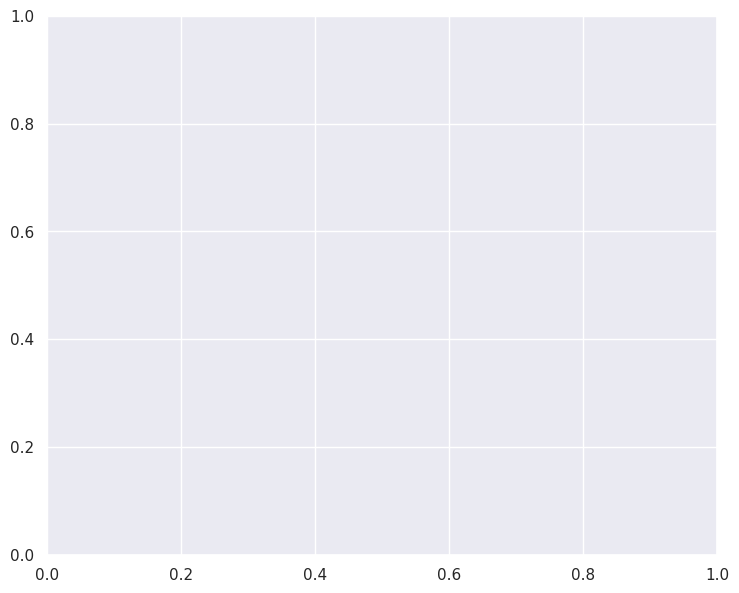

In [14]:
# Creating and saving a Bar Chart Animation:
selected = racing_bar_filled.iloc[-1, :].sort_values(ascending = False)[:20].index
data = racing_bar_filled[selected].round()

fig, ax = plt.subplots(figsize = (9.3, 7))
fig.subplots_adjust(left = 0.18)

#Number of frames:
no_of_frames = data.shape[0]

# Initiating the barplot with the first rows of the dataframe:
bars = sns.barplot(y = data.columns, x = data.iloc[0, :], orient = 'h', ax = ax)
ax.set_xlim(0, 1500)
texts = [ax.text(0, i, 0, va = 'center') for i in range(data.shape[1])]
title_text = ax.text(650, -1, 'Date: ', fontsize = 12)
ax.set_xlabel('')
ax.set_ylabel(None)

def animate(i):
  y = data.iloc[i, :]

  # Updating the title of the barplot axis:
  title_text.set_text(f'Date: {str(data.index[i].date())}')

  # updating elements in both plots:
  for j, b, in enumerate(bars.patches):
    # updating each bar's height:
    b.set_width(y[j])

    # updating text for each bar (optional)
    texts[j].set_text(f'${y[j].astype(int)}M')
    texts[j].set_x(y[j])

animation = FuncAnimation(fig, animate, repeat = False,
                          frames = no_of_frames,
                          interval = 1, blit = False)
animation.save('goals.gif', writer = 'imagemagick', fps = 120)
plt.close()